In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import tldextract

In [2]:
# =============================
# 1️⃣ Load & Preprocess Data
# =============================
fake_news = pd.read_csv('data/fake_gossipcop.csv')
real_news = pd.read_csv('data/real_gossipcop.csv')

fake_news['labels'] = 1
real_news['labels'] = 0

data = pd.concat([fake_news[['title', 'labels', 'news_url']], real_news[['title', 'labels', 'news_url']]], ignore_index=True)
data.dropna(subset=['title'], inplace=True)

# =============================
# 2️⃣ Extract & Normalize URL Features
# =============================
def extract_url_features(url):
    if isinstance(url, float):
        url = str(url)
    ext = tldextract.extract(url)
    return {
        'domain': ext.domain,
        'subdomain': ext.subdomain,
        'url_length': len(url),
        'has_query': 1 if '?' in url else 0,
        'has_hyphens': 1 if '-' in url else 0,
        'has_numbers': 1 if any(c.isdigit() for c in url) else 0,
    }

url_features = data['news_url'].apply(extract_url_features)
url_features_df = pd.DataFrame(url_features.tolist())

# Encode categorical features
url_features_encoded = pd.get_dummies(url_features_df, columns=['domain', 'subdomain'])

# Normalize
scaler = StandardScaler()
url_features_encoded = pd.DataFrame(scaler.fit_transform(url_features_encoded), columns=url_features_encoded.columns)

# Save the scaler for inference
#joblib.dump(scaler, "lstm_scaler.pkl")


In [3]:
# =============================
# 3️⃣ Convert Text to Embeddings (TF-IDF)
# =============================
vectorizer = TfidfVectorizer(max_features=5000)
title_features_vectorized = vectorizer.fit_transform(data['title']).toarray()

# Save vectorizer for inference
#joblib.dump(vectorizer, "lstm_vectorizer.pkl")

# Align lengths
min_length = min(len(title_features_vectorized), len(url_features_encoded))
title_features_vectorized = title_features_vectorized[:min_length]
url_features_encoded = url_features_encoded.iloc[:min_length]
data = data.iloc[:min_length]

# =============================
# 4️⃣ Apply SMOTE for Balancing
# =============================
combined_features = np.hstack([title_features_vectorized, url_features_encoded])
smote = SMOTE(random_state=42)
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, data['labels'])

# =============================
# 5️⃣ Train/Validation/Test Split
# =============================
train_features, test_features, train_labels, test_labels = train_test_split(combined_features_resampled, labels_resampled, test_size=0.2, random_state=42)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
def to_tensor(features, labels):
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels.values, dtype=torch.long)

train_features_tensor, train_labels_tensor = to_tensor(train_features, train_labels)
val_features_tensor, val_labels_tensor = to_tensor(val_features, val_labels)
test_features_tensor, test_labels_tensor = to_tensor(test_features, test_labels)

# =============================
# 6️⃣ Create PyTorch Dataset & Dataloader
# =============================
class FakeNewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx].unsqueeze(0), self.labels[idx]  # Reshape for LSTM

batch_size = 32
train_dataset = FakeNewsDataset(train_features_tensor, train_labels_tensor)
val_dataset = FakeNewsDataset(val_features_tensor, val_labels_tensor)
test_dataset = FakeNewsDataset(test_features_tensor, test_labels_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [4]:
# =============================
# 7️⃣ Define LSTM Model
# =============================
class LSTMFakeNewsClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMFakeNewsClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Apply softmax for probabilities

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Last time step output
        return self.softmax(out)

# Model Initialization
input_dim = train_features.shape[1]
hidden_dim = 128
num_layers = 2
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMFakeNewsClassifier(input_dim, hidden_dim, num_layers, num_classes).to(device)


In [5]:
# =============================
# 8️⃣ Training Setup
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_features, batch_labels in tqdm(train_dataloader):
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}")

    # Validation
    model.eval()
    val_preds = []
    val_labels_list = []
    with torch.no_grad():
        for batch_features, batch_labels in val_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(batch_labels.cpu().numpy())

    val_acc = accuracy_score(val_labels_list, val_preds)
    print(f"Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "best_fake_news_lstm_gossicop.pth")
        best_val_acc = val_acc

print("Best model saved!")

# =============================
# 9️⃣ Final Model Evaluation
# =============================
model.load_state_dict(torch.load("best_fake_news_lstm_gossicop.pth"))

100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:31<00:00, 24.22it/s]


Epoch [1/10], Loss: 0.5188861811334264
Validation Accuracy: 0.8353771832032701


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:30<00:00, 24.46it/s]


Epoch [2/10], Loss: 0.44171116193030596
Validation Accuracy: 0.8543292456335935


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:30<00:00, 24.50it/s]


Epoch [3/10], Loss: 0.42355139925583823
Validation Accuracy: 0.8669639539204756


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:30<00:00, 24.45it/s]


Epoch [4/10], Loss: 0.41585242177410203
Validation Accuracy: 0.8409513192121888


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:31<00:00, 24.33it/s]


Epoch [5/10], Loss: 0.40731924772262573
Validation Accuracy: 0.8725380899293943


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:30<00:00, 24.43it/s]


Epoch [6/10], Loss: 0.40036380046897396
Validation Accuracy: 0.8695652173913043


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:30<00:00, 24.59it/s]


Epoch [7/10], Loss: 0.39744043610055035
Validation Accuracy: 0.8725380899293943


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:30<00:00, 24.49it/s]


Epoch [8/10], Loss: 0.39220750320067965
Validation Accuracy: 0.8795986622073578


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:31<00:00, 24.26it/s]


Epoch [9/10], Loss: 0.3881342346082433
Validation Accuracy: 0.8773690078037905


100%|████████████████████████████████████████████████████████████████████████████████| 757/757 [00:30<00:00, 24.63it/s]


Epoch [10/10], Loss: 0.3856982965529201
Validation Accuracy: 0.8855444072835377
Best model saved!


<All keys matched successfully>

Accuracy: 0.8855444072835377
              precision    recall  f1-score   support

        Real       0.89      0.88      0.88      1323
        Fake       0.88      0.89      0.89      1368

    accuracy                           0.89      2691
   macro avg       0.89      0.89      0.89      2691
weighted avg       0.89      0.89      0.89      2691



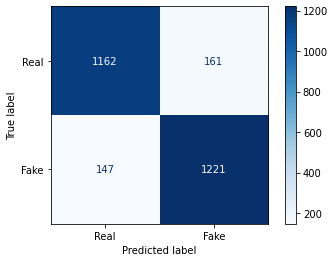

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(val_labels_list, val_preds)
print("Accuracy:", accuracy)

print(classification_report(val_labels_list, val_preds, target_names=['Real', 'Fake']))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(val_labels_list, val_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Corrected LSTM input shape
# Used TF-IDF embeddings instead of BoW
# Applied Softmax activation in LSTM model
# Added validation set
# Saved vectorizer & scaler for inference